In [1]:
!pip install trackintel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.1/156.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.2 MB/s eta 0:00:00
  Created wheel for similaritymeasures: filename=similaritymeasures-1.2.0-py3-none-any.whl size=15433 sha256=bec8d44f7322abc7744a247a4418843842c13c26e02746ec8cc36753a9621b50
  Stored in directory: /root/.cache/pip/wheels/0f/8b/4f/b9dd125a4fa600b2d9ee19e728feb3f24bf19bdfd9eeda9191
Successfully built similaritymeasures
  Atte

In [2]:
import numpy as np
import pandas as pd
# import dask.dataframe as dd
import geopandas as gpd
import trackintel as ti
from shapely.geometry import Point
from shapely.wkt import loads as load_wkt
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

mobility_city = pd.read_csv('/content/drive/MyDrive/NTU/Y4S1/cityD_challengedata.csv.gz', compression='gzip')
# mobility_cityD = pd.read_csv('test.csv')
mobility_city.head(15)

,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98
2,0,0,16,162,99
3,0,0,17,149,97
4,0,0,18,144,98
5,0,0,20,160,100
6,0,0,21,155,99
7,0,0,22,143,98
8,0,0,23,163,94
9,0,0,24,146,97


In [6]:
poi_city = pd.read_csv('/content/drive/MyDrive/NTU/Y4S1/POIdata_cityD.csv')
poi_categories = pd.read_csv('/content/POI_datacategories.csv')
# print(poi_city.head())

In [7]:
# Check if category IDs in POI data map to indices in the categories file
poi_categories.reset_index(inplace=True)
poi_categories.columns = ['category', 'category_name']  # Rename columns for clarity

# Ensure that category indices match those in POI data
category_mapping = dict(zip(poi_categories['category'], poi_categories['category_name']))

# Map the category names to the POI data
poi_city['category_name'] = poi_city['category'].map(category_mapping)

### **EDA (Mobility Data)**

In [8]:
# Convert date and time to a single datetime column if needed
# Identify rows with invalid coordinates
invalid_coordinates = mobility_city[
    (mobility_city['x'] < 1) | (mobility_city['x'] > 500) |
    (mobility_city['y'] < 1) | (mobility_city['y'] > 500) |
    (mobility_city['x'] == 999) | (mobility_city['y'] == 999)
]

# Group by date to see which days have invalid coordinates
invalid_days = invalid_coordinates.groupby(invalid_coordinates['d']).size()

# Print the results
print("Days with invalid coordinates (out of grid):")
print(invalid_days)

# Determine the minimum and maximum values for x and y
min_x = mobility_city['x'].min()
max_x = mobility_city['x'].max()
min_y = mobility_city['y'].min()
max_y = mobility_city['y'].max()

Days with invalid coordinates (out of grid):
d
60    55196
61    57174
62    51596
63    45680
64    56110
65    58546
66    65679
67    59396
68    57548
69    49668
70    44252
71    56476
72    56591
73    55630
74    55191
dtype: int64


In [9]:
# Filter and drop rows with invalid coordinates for days passing 30 and invalid days
mobility_city = mobility_city[~((mobility_city['d'] > 31) | ((mobility_city['x'] < 1) | (mobility_city['x'] > 500) |
                                    (mobility_city['y'] < 1) | (mobility_city['y'] > 500) |
                                    (mobility_city['x'] == 999) | (mobility_city['y'] == 999)))]

# Optionally, reset the index after dropping
mobility_city.reset_index(drop=True, inplace=True)

# Print the cleaned DataFrame shape
print("Cleaned DataFrame Shape:", mobility_city.shape)

# Step 1: Rename columns to match trackintel requirements
mobility_city.rename(columns={'uid': 'user_id'}, inplace=True)

# Step 2: Combine date (`d`) and time (`t`) into a datetime column, `tracked_at`
base_date = pd.Timestamp("2024-01-01")  # Adjust 'base_date' accordingly
base_date = base_date.tz_localize('UTC')

# Convert t to timedelta in minutes (30 minutes per unit of t)
mobility_city['tracked_at'] = base_date + pd.to_timedelta(mobility_city['d'], unit='D') + \
                                pd.to_timedelta(mobility_city['t'] * 30, unit='m')
# Step 3: Create `geom` column
mobility_city['geom'] = mobility_city.apply(lambda row: Point(row['x'], row['y']), axis=1)

print(mobility_city.head(35))

# Step 4: Remove unnecessary columns
mobility_city = mobility_city[['user_id', 'tracked_at', 'geom']]

# Convert to GeoDataFrame
pfs_city = gpd.GeoDataFrame(mobility_city, geometry='geom')
pfs_city = pfs_city.set_crs("EPSG:3344", allow_override=True)

Cleaned DataFrame Shape: (3624259, 5)


<ipython-input-9-6604d79d2bf2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobility_city.rename(columns={'uid': 'user_id'}, inplace=True)


    user_id  d   t    x    y                tracked_at             geom
0         0  0  13  133  103 2024-01-01 06:30:00+00:00  POINT (133 103)
1         0  0  14  143   98 2024-01-01 07:00:00+00:00   POINT (143 98)
2         0  0  16  162   99 2024-01-01 08:00:00+00:00   POINT (162 99)
3         0  0  17  149   97 2024-01-01 08:30:00+00:00   POINT (149 97)
4         0  0  18  144   98 2024-01-01 09:00:00+00:00   POINT (144 98)
5         0  0  20  160  100 2024-01-01 10:00:00+00:00  POINT (160 100)
6         0  0  21  155   99 2024-01-01 10:30:00+00:00   POINT (155 99)
7         0  0  22  143   98 2024-01-01 11:00:00+00:00   POINT (143 98)
8         0  0  23  163   94 2024-01-01 11:30:00+00:00   POINT (163 94)
9         0  0  24  146   97 2024-01-01 12:00:00+00:00   POINT (146 97)
10        0  0  26  144   97 2024-01-01 13:00:00+00:00   POINT (144 97)
11        0  0  27  144   99 2024-01-01 13:30:00+00:00   POINT (144 99)
12        0  0  28  150   97 2024-01-01 14:00:00+00:00   POINT (

In [10]:
print("Positionfixes:")
print("Number of Positionfixes:", pfs_city.shape[0])  # Number of rows in Positionfixes
print(pfs_city.head())

# Function to check if a Point object is within the valid range
def is_valid_point(point):
    return 0 <= point.x <= 200 and 0 <= point.y <= 200

# Check for valid coordinates in the 'points' column
valid_positionfixes = pfs_city[pfs_city['geom'].apply(is_valid_point)]

# Find the invalid position fixes
invalid_positionfixes = pfs_city[~pfs_city.index.isin(valid_positionfixes.index)]

# Display the count and the invalid position fixes
print("Total Position Fixes:", len(pfs_city))
print("Total Invalid Position Fixes:", len(invalid_positionfixes))

if not invalid_positionfixes.empty:
    print("Invalid Position Fixes:")
    print(invalid_positionfixes[['user_id', 'tracked_at', 'geom', 'points']])
else:
    print("All Position Fixes are within the valid range.")

Positionfixes:
Number of Positionfixes: 3624259
   user_id                tracked_at                     geom
0        0 2024-01-01 06:30:00+00:00  POINT (133.000 103.000)
1        0 2024-01-01 07:00:00+00:00   POINT (143.000 98.000)
2        0 2024-01-01 08:00:00+00:00   POINT (162.000 99.000)
3        0 2024-01-01 08:30:00+00:00   POINT (149.000 97.000)
4        0 2024-01-01 09:00:00+00:00   POINT (144.000 98.000)
Total Position Fixes: 3624259
Total Invalid Position Fixes: 0
All Position Fixes are within the valid range.


### **EDA (POI Data)**

In [11]:
# Convert POIs to a GeoDataFrame to work with spatial operations
poi_city['geom'] = poi_city.apply(lambda row: Point(row['x'], row['y']), axis=1)
# Step 4: Remove unnecessary columns
poi_city = poi_city[['category_name', 'POI_count', 'geom']]
poi_city = gpd.GeoDataFrame(poi_city, geometry='geom')
print(poi_city.head())

     category_name  POI_count                      geom
0  Transit Station          1  POINT (1.00000 11.00000)
1         Laundry           2  POINT (1.00000 55.00000)
2           Casino          1  POINT (1.00000 55.00000)
3    Lawyer Office          1  POINT (1.00000 56.00000)
4        IT Office          1  POINT (1.00000 56.00000)


# 2. Generate Staypoints and Triplegs


In [12]:
pfs_city, sp_city = ti.preprocessing.generate_staypoints(
    pfs_city,
    method='sliding',
    gap_threshold=3*60, # To avoid including too large missing signal gaps, set ‘gap_threshold’ to a small value, e.g., 15 min.
    include_last=False,
    print_progress=True,
    dist_threshold=100, # Maximum distance in meters (10 grids)
    time_threshold=6*60,
    exclude_duplicate_pfs=True,  # Duplicates can lead to problems in later processing steps (e.g., when generating triplegs). It is not recommended to set this to False.
    n_jobs=5 # Number of parallel jobs for processing
)

100%|██████████| 5984/5984 [02:45<00:00, 36.16it/s]


In [13]:
print("\nStaypoints:")
print("Number of Staypoints:", sp_city.shape[0])  # Number of rows in staypoints
print(sp_city.head())


Staypoints:
Number of Staypoints: 9344
    user_id                started_at               finished_at  \
id                                                                
0         1 2024-01-02 10:00:00+00:00 2024-01-02 16:00:00+00:00   
1         1 2024-01-10 16:30:00+00:00 2024-01-10 22:30:00+00:00   
2         3 2024-01-01 23:30:00+00:00 2024-01-02 05:30:00+00:00   
3         8 2024-01-23 23:00:00+00:00 2024-01-24 06:30:00+00:00   
4         8 2024-01-31 21:30:00+00:00 2024-02-01 03:30:00+00:00   

                       geom  
id                           
0      POINT (33.000 7.000)  
1      POINT (31.000 1.000)  
2     POINT (191.000 1.000)  
3   POINT (112.000 133.000)  
4   POINT (112.000 133.000)  


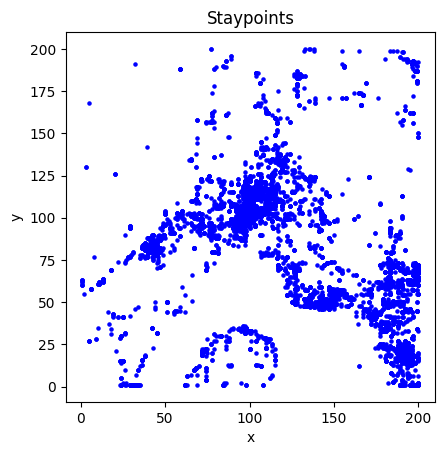

In [14]:
# Extract the coordinates of each LINESTRING into a new column
sp_city['points'] = sp_city['geom'].apply(lambda geom: list(geom.coords))

# Flatten the list to create a DataFrame of individual points
staypoints = sp_city.explode('points')

# Create a GeoDataFrame from the exploded points
staypoints['geometry'] = gpd.points_from_xy(*zip(*staypoints['points']))
staypoints = gpd.GeoDataFrame(staypoints, geometry='geometry')

# Plotting the individual staypoints
staypoints.plot(marker='o', color='blue', markersize=5)
plt.title('Staypoints')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [15]:
# Step 2: Generate triplegs from staypoints
pfs_city, tpls_city = ti.preprocessing.generate_triplegs(
    pfs_city,
    sp_city,
    method='overlap_staypoints',
    gap_threshold = 60 * 6
)

# gap_threshold determines how much time can pass between two staypoints for them to be considered part of the same tripleg.
# Step 3: Display the number of rows and generated staypoints and triplegs

print("\nNumber of Triplegs:", tpls_city.shape[0])  # Number of rows in triplegs
print("Triplegs:")
print(tpls_city.head().to_string())

/usr/local/lib/python3.10/dist-packages/trackintel/preprocessing/positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
/usr/local/lib/python3.10/dist-packages/trackintel/preprocessing/positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
/usr/local/lib/python3.10/dist-packages/trackintel/preprocessing/positionfixes.py:573: UserWarning: The positionfixes with ids [   1969    197


Number of Triplegs: 135747
Triplegs:
    user_id                started_at               finished_at                                                                                                                                                                                                                                                                                                                                                                                                                                                                geom
id                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [16]:
# Display the generated staypoints and triplegs
# print("Positionfixes:")
# print(pfs_cityD.head())
# print("Staypoints:")
# print(sp_cityD.head())
print("\nTriplegs:")
print(tpls_city.head())


Triplegs:
    user_id                started_at               finished_at  \
id                                                                
0         0 2024-01-01 06:30:00+00:00 2024-01-02 00:00:00+00:00   
1         0 2024-01-02 08:00:00+00:00 2024-01-02 20:00:00+00:00   
2         0 2024-01-03 04:00:00+00:00 2024-01-03 18:30:00+00:00   
3         0 2024-01-04 05:30:00+00:00 2024-01-04 19:30:00+00:00   
4         0 2024-01-05 04:30:00+00:00 2024-01-05 22:00:00+00:00   

                                                 geom  
id                                                     
0   LINESTRING (133.000 103.000, 143.000 98.000, 1...  
1   LINESTRING (115.000 93.000, 114.000 114.000, 1...  
2   LINESTRING (119.000 99.000, 131.000 103.000, 1...  
3   LINESTRING (124.000 99.000, 143.000 98.000, 14...  
4   LINESTRING (118.000 98.000, 133.000 103.000, 1...  


In [17]:
tpls_city.to_csv('tpls_cityD.csv')

Reading the trip leg file

In [18]:
from shapely.wkt import loads
from torch.utils.data import Dataset, DataLoader, random_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn

# Load your dataset (replace with the actual filename)
file_path = "tpls_cityD.csv"  # Update with your dataset path
data = pd.read_csv(file_path)

# Parse the 'geom' column to extract coordinates
def extract_coordinates(linestring):
    geom = loads(linestring)  # Convert WKT string to Shapely geometry
    return list(geom.coords)

# # Define the LSTM Model
# class LocationLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LocationLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size, 128),
#             nn.ReLU(),
#             nn.Linear(128, output_size)
#         )

#     def forward(self, x):
#         output, (hn, cn) = self.lstm(x)
#         out = self.fc(hn[-1])  # Use the last hidden state for prediction
#         return out

class LocationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LocationLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Single linear layer

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Use the last hidden state for prediction
        return out

# Custom Dataset
class LocationDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

# Extract input sequences and labels
inputs = []
labels = []

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for index, row in data.iterrows():
    coordinates = extract_coordinates(row['geom'])

    if len(coordinates) > 2:
        inputs.append(coordinates[:-1])  # All but last coordinate
        labels.append(coordinates[-1:])  # get last coordinate

# Convert inputs and labels to arrays
inputs = pad_sequences(inputs, padding='post', dtype='float32')  # Pad sequences
labels = np.array(labels)

# Convert data to tensors
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32).squeeze(1)

# Create the full dataset
dataset = LocationDataset(inputs_tensor, labels_tensor)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, prefetch_factor=2)


Using device: cuda


Training the model

In [ ]:
# Initialize the model, loss function, and optimizer
input_size = 2
hidden_size = 128
output_size = 2
learning_rate = 1e-3
epochs = 50

model = LocationLSTM(input_size, hidden_size, output_size).to(device)  # Move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

best_loss = float('inf')  # Initialize best loss to a very large value
best_model_path = "/content/drive/MyDrive/NTU/Y4S1/best_lstm_model_2.pth"

# Training Loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_inputs, batch_labels in train_loader:
        # Move data to the same device as the model
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        predictions = model(batch_inputs)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate average loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_predictions = model(val_inputs)
            loss = criterion(val_predictions, val_labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Save the model if the validation loss improves
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss Improved: {avg_val_loss:.4f}. Model Saved!")

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Evaluate the best model on the test set
model.load_state_dict(torch.load(best_model_path))  # Load the best model
model.eval()  # Set model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        predictions = model(batch_inputs)
        loss = criterion(predictions, batch_labels)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Epoch [1/50], Validation Loss Improved: 1979.9577. Model Saved!
Epoch [1/50], Train Loss: 2273.4507, Validation Loss: 1979.9577
Epoch [2/50], Validation Loss Improved: 1625.8793. Model Saved!
Epoch [2/50], Train Loss: 1940.0874, Validation Loss: 1625.8793
Epoch [3/50], Validation Loss Improved: 379.0939. Model Saved!
Epoch [3/50], Train Loss: 930.9737, Validation Loss: 379.0939
Epoch [4/50], Validation Loss Improved: 112.8097. Model Saved!
Epoch [4/50], Train Loss: 155.5570, Validation Loss: 112.8097
Epoch [5/50], Validation Loss Improved: 107.0861. Model Saved!
Epoch [5/50], Train Loss: 116.3423, Validation Loss: 107.0861
Epoch [6/50], Validation Loss Improved: 95.9580. Model Saved!
Epoch [6/50], Train Loss: 108.1563, Validation Loss: 95.9580
Epoch [7/50], Train Loss: 101.8300, Validation Loss: 113.3768
Epoch [8/50], Train Loss: 99.6687, Validation Loss: 118.1898
Epoch [9/50], Train Loss: 117.0212, Validation Loss: 113.6159
Epoch [10/50], Train Loss: 98.8212, Validation Loss: 98.3839


<ipython-input-4-b7650cf84e5e>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))  # Load the best model


Test Loss: 84.4761


Loading the model and testing the model

In [19]:
# Initialize the model, loss function, and optimizer
input_size = 2
hidden_size = 128
output_size = 2

model = LocationLSTM(input_size, hidden_size, output_size).to(device)  # Move model to GPU
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

best_model_path = "/content/drive/MyDrive/NTU/Y4S1/best_lstm_model_2.pth"
# best_model_path = "cityA.pth"

# Load the trained model weights
model.load_state_dict(torch.load(best_model_path))

# Set the model to evaluation mode
model.eval()

# Initialize variables for loss and predictions
test_loss = 0.0
all_predictions = []
all_labels = []

# Evaluation using the test_loader
with torch.no_grad():  # Disable gradient computation
    for batch_inputs, batch_labels in test_loader:
        # Move data to the same device as the model
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        # Make predictions
        predictions = model(batch_inputs)

        # Calculate loss (optional, for evaluation)
        loss = criterion(predictions, batch_labels)
        test_loss += loss.item()

        # Collect predictions and labels for further analysis
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(batch_labels.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)
print(f"Average Test Loss: {avg_test_loss:.4f}")

# Process predictions (e.g., flatten arrays)
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Display or analyze results
print("Predictions:", all_predictions)
print("Ground Truth Labels:", all_labels)

<ipython-input-19-e1858a05eeb6>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Average Test Loss: 83.5979
Predictions: [[106.88886  102.904724]
 [ 86.96301  110.650955]
 [197.0793    56.769814]
 ...
 [110.22112  118.0504  ]
 [115.22315  120.516014]
 [101.80196  115.29451 ]]
Ground Truth Labels: [[104. 103.]
 [ 90. 109.]
 [200.  67.]
 ...
 [108. 113.]
 [115. 121.]
 [101. 116.]]


In [20]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(all_labels, all_predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 83.6137
